### Feature Engineering and Data Processing: Y-SIGN data 2022-03
This file is for R&D of features for the model. Features should be created using functions that can then be cut and paste into the model_functions.py file to be imported into the final model .ipynb file.

We should split our data before we do any of this! (before splitting, need expand the intersections data to every road, or just use the direct adjacant values).

In [55]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('dark_background')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Import the train data (LTS data + intersections, neighbourhoods ...)

#### Data Processing

Import the data

In [29]:
train_data = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/ysign_dropoff2_iter15_train.csv')
train_data.head()

,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,ysign vehicle,ysign ped,high access
0,26720,26722,1137670,3025,Bocastle Ave,13453368,13453237,0,95.530596,1137670,1,0.000883,LINESTRING (628767.3368918777 4843212.59019024...,4790.250,973.25,1
1,45540,45542,111369,8220,Kenmark Blvd,13453101,13453173,0,228.998686,111369,1,0.002671,LINESTRING (639762.0980769163 4843420.41458969...,2446.250,329.25,1
2,14362,14363,14048139,3053,Brandon Ave,13463765,14048141,0,49.852955,14048139,1,0.000607,LINESTRING (625363.2529044797 4836317.83499265...,1582.625,73.25,1
3,36418,36420,2689046,3803,Lake Shore Blvd E,13466078,13466003,0,105.443542,2689046,4,0.001222,LINESTRING (633798.3739368191 4834729.22944054...,1327.250,7.00,0
4,15812,15813,14040464,11872,Ln 1 W Clinton N Gore,14040383,14040467,0,22.935001,14040464,1,0.000214,LINESTRING (627870.1851326771 4834730.84276338...,906.375,451.50,1


In [30]:
train_data['ysign vehicle'].quantile(0.75)

5556.75

Create a function that drops outliers in the ysign data, <br>
We don't want to remove outliers based on YSIGN, but instead outliers should be removed during data cleaning before the test train split (based on the overall 8 hour peak) <br>
Even then, we don't really want to discount any measurements as these are "peaks" over time. lets not remove outliers <br>
We can however remove all the rows we don't want

In [31]:
def ysign_droprows(data, keep):
    """
    Function drops rows that are not passed in 'keep' list.
    """
    
    #Drop
    data_drop = data[keep]
    
    return data_drop

keep_rows = ['OBJECTID',	'GEO_ID',	'ONE_WAY_DI',	
             'LTS',	'geometry',	'ysign vehicle',	
             'ysign ped',	'high access']

train_data = ysign_droprows(train_data, keep_rows)
train_data.head()

,OBJECTID,GEO_ID,ONE_WAY_DI,LTS,geometry,ysign vehicle,ysign ped,high access
0,26722,1137670,0,1,LINESTRING (628767.3368918777 4843212.59019024...,4790.250,973.25,1
1,45542,111369,0,1,LINESTRING (639762.0980769163 4843420.41458969...,2446.250,329.25,1
2,14363,14048139,0,1,LINESTRING (625363.2529044797 4836317.83499265...,1582.625,73.25,1
3,36420,2689046,0,4,LINESTRING (633798.3739368191 4834729.22944054...,1327.250,7.00,0
4,15813,14040464,0,1,LINESTRING (627870.1851326771 4834730.84276338...,906.375,451.50,1


Lets scale the ysign data with a standard scaler

In [32]:
from sklearn.preprocessing import StandardScaler
def ysign_scale(data, scale_feats):
    """
    Scales the passed columns of the ysign data.
    """
    
    # Create scaler
    scaler = StandardScaler()
    scaler.fit(data[scale_feats])
    
    scaled = data[scale_feats].copy()
    
    # Convert numeric features to standard units
    scaled.iloc[:, :] = scaler.transform(scaled)
    
    data[scale_feats] = scaled
    
    return data
    
train_data = ysign_scale(train_data, ['ysign vehicle', 'ysign ped'])
train_data.head()

,OBJECTID,GEO_ID,ONE_WAY_DI,LTS,geometry,ysign vehicle,ysign ped,high access
0,26722,1137670,0,1,LINESTRING (628767.3368918777 4843212.59019024...,0.094336,0.258095,1
1,45542,111369,0,1,LINESTRING (639762.0980769163 4843420.41458969...,-0.330468,-0.118231,1
2,14363,14048139,0,1,LINESTRING (625363.2529044797 4836317.83499265...,-0.486982,-0.267827,1
3,36420,2689046,0,4,LINESTRING (633798.3739368191 4834729.22944054...,-0.533264,-0.306540,0
4,15813,14040464,0,1,LINESTRING (627870.1851326771 4834730.84276338...,-0.609539,-0.046794,1


We also suspect that there is a geospatial relationship for LTS. If we do PCA like in assignment 7 in the centroids of the centrelines, <br>
and then dummy encode regions in toronto along the principle components, we can use this as a feature.

In [ ]:
from shapely import wkt

In [196]:
from sklearn.decomposition import PCA
def add_regions(data, components, bins):
    """
    function extract PC of Toronto's geometry and bins it into a # of regions.
    """
    # Extract the centroids of the LINESTRING geometry.
    # Also return the x y components of these centroids
    data_g = data.copy()
    data_g['geometry'] = data_g['geometry'].apply(wkt.loads)
    train_data_gpd = gpd.GeoDataFrame(data_g, crs="EPSG:26917")
    train_data_gpd.head()
    
    centroids = train_data_gpd['geometry'].centroid
    centroids_df = pd.DataFrame(data={'x':centroids.x, 'y':centroids.y})
    
    # Scale features.
    scaler = StandardScaler().fit(centroids_df)
    X_scaled = scaler.transform(centroids_df)
    
    # Create/fit PCA function.
    pca = PCA(n_components=components)
    X_transformed = pca.fit_transform(X_scaled)
    X_transformed_df = pd.DataFrame(X_transformed)
    
    # Print results.
    for i in range(components):
        print('Principal component', i)
        print('explains', (pca.explained_variance_ratio_[i] * 100), '% of the variance in "lon" and "lat".')
    
    # Return inversed values
    X_new = pca.inverse_transform(X_transformed)
    X_new = scaler.inverse_transform(X_new)
    X_new_df = pd.DataFrame(X_new)
    
    # Bin geographic regions based on components
    out = pd.qcut(X_transformed_df[0], bins, labels=np.arange(1,bins+1,1))
    out2 = pd.qcut(X_transformed_df[1], bins, labels=np.arange(1,bins+1,1))   
    
    #Append the bin labels to the geo data.
    centroids_df['x_bin'] = out
    centroids_df['y_bin'] = out2
    
    return X_transformed_df, centroids_df
    
pcs, geo_points = add_regions(train_data, 2, 3)

Principal component 0
explains 74.76311274393491 % of the variance in "lon" and "lat".
Principal component 1
explains 25.236887256065092 % of the variance in "lon" and "lat".


In [198]:
geo_points

,x,y,x_bin,y_bin
0,628754.811406,4.843259e+06,2,3
1,639870.126537,4.843417e+06,3,1
2,625339.414149,4.836311e+06,1,2
3,633842.998353,4.834757e+06,2,1
4,627866.638004,4.834742e+06,1,1
...,...,...,...,...
47328,631408.801545,4.846232e+06,3,3
47329,628991.097311,4.839524e+06,2,2
47330,626220.369744,4.835078e+06,1,2
47331,644584.739830,4.851897e+06,3,2


Text(0, 0.5, 'y')

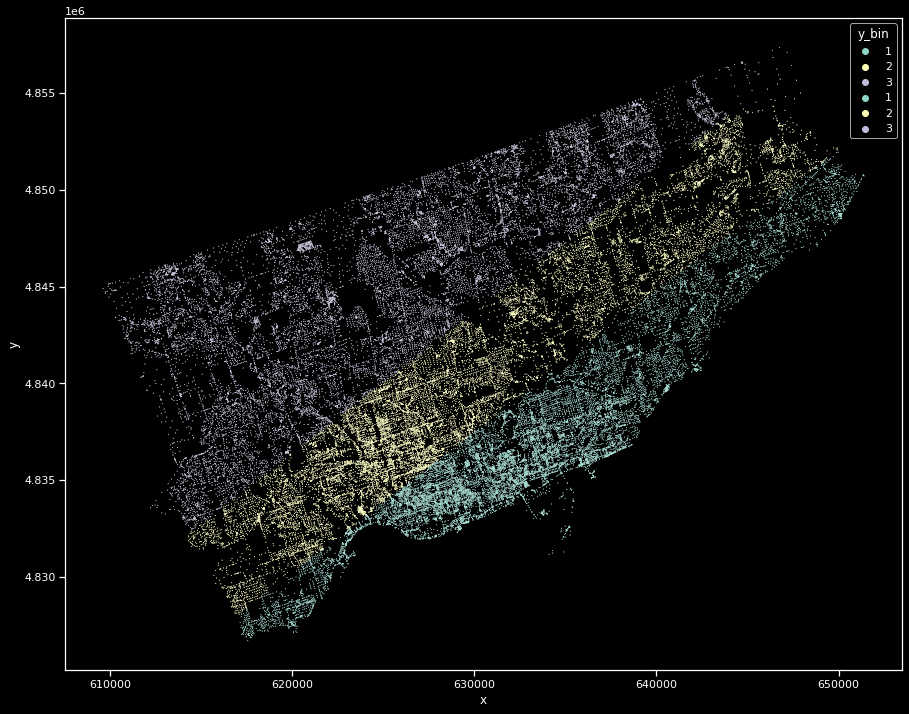

In [215]:
fig, axs = plt.subplots(figsize=(15,12))

ax = sns.scatterplot(geo_points['x'], geo_points['y'], s=0.8, hue=geo_points['y_bin'])
ax = sns.scatterplot(geo_points['x'], geo_points['y'], s=0.4, hue=geo_points['y_bin'])

plt.xlabel('x')
plt.ylabel('y')

In [35]:
sns.scatterplot(train['pickup_lon'], 
                train['pickup_lat'], 
                hue=out, s=1, alpha=0.2, label='Regions')

#### Advanced cross validation
We may want to do an advanced, spatial cross validation due to the nature of the data.<br>
create a function that performs this cross val